<a href="https://colab.research.google.com/github/MuganziJames/AIML-Disease-Prediction-Project/blob/main/colab_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Setup and Imports
Loading required libraries for data processing, model training, and visualization.


# Heart Disease Prediction — Colab Training and Evaluation

## 2. Colab File Upload
When running in Google Colab, this cell will prompt you to upload the heart_dataset.csv file.


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


## 3. Loading the Dataset
This cell loads the heart disease dataset from various possible locations and displays a preview.


In [4]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import files
    uploaded = files.upload()



Saving heart_dataset.csv to heart_dataset.csv


## 4. Creating Target Variable (if needed)
If the dataset doesn't have a target column, this cell creates one based on clinical risk factors.


In [5]:
from pathlib import Path
possible_paths = ['heart_dataset.csv', 'data/heart_dataset.csv', '../data/heart_dataset.csv', '/content/heart_dataset.csv']
for p in possible_paths:
    if Path(p).exists():
        data_path = p
        break
df = pd.read_csv(data_path)
df.head()


,age,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,sex_Female,sex_Male,cp_asymptomatic,cp_atypical angina,cp_non-anginal,cp_typical angina
0,58,130,220,1,normal,150,False,1.4,flat,0,fixed defect,0,1,0,0,0,1
1,67,160,276,0,lv hypertrophy,108,True,1.5,flat,3,normal,0,1,1,0,0,0
2,42,120,230,0,normal,170,False,1.0,upsloping,0,reversable defect,1,0,0,0,1,0
3,50,130,210,0,lv hypertrophy,158,False,0.8,flat,0,normal,0,1,0,0,1,0
4,45,114,230,0,normal,165,False,1.1,downsloping,0,normal,1,0,0,1,0,0


## 5. Feature Preparation
Separating features and target variable, identifying categorical and numerical columns.


In [6]:
if 'target' not in df.columns:
    risk = np.zeros(len(df), dtype=int)
    if 'age' in df.columns:
        risk += (df['age'] >= 55).astype(int)
    if 'trestbps' in df.columns:
        risk += (df['trestbps'] >= 140).astype(int)
    if 'chol' in df.columns:
        risk += (df['chol'] >= 240).astype(int)
    if 'oldpeak' in df.columns:
        risk += pd.to_numeric(df['oldpeak'], errors='coerce').fillna(0).ge(1.0).astype(int)
    if 'exang' in df.columns:
        risk += df['exang'].astype(str).isin(['True','1','true']).astype(int)
    if 'cp_asymptomatic' in df.columns:
        risk += (df['cp_asymptomatic'] == 1).astype(int)
    df['target'] = (risk >= 2).astype(int)


## 6. Preprocessing Pipeline
Setting up transformers for:
- Missing value imputation (median for numeric, most frequent for categorical)
- Standardization of numeric features
- One-hot encoding of categorical features


In [7]:
target_col = 'target'
feature_cols = [c for c in df.columns if c != target_col]
X = df[feature_cols]
y = df[target_col]
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()


## 7. Train-Test Split
Splitting data into training (80%) and testing (20%) sets with stratification.


In [9]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


## 8. Model Definition
Creating three different models:
- Logistic Regression: Linear classifier
- Decision Tree: Tree-based classifier
- Random Forest: Ensemble of decision trees


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y if y.nunique()==2 and len(y)>=20 else None
)


## 9. Model Training and Evaluation
For each model:
1. Train on the training data
2. Make predictions on test data
3. Calculate performance metrics:
   - Accuracy
   - Precision
   - Recall
   - F1-score
   - ROC-AUC (for models that support probability predictions)


In [10]:
models = {
    'logistic_regression': LogisticRegression(max_iter=1000, random_state=42),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42, n_jobs=-1)
}

pipelines = {name: Pipeline(steps=[('preprocess', preprocessor), ('model', clf)]) for name, clf in models.items()}


## 10. Best Model Selection
Identifying the best performing model based on F1-score.


In [11]:
results = []
trained = {}
for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    metrics = {
        'model': name,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1': f1_score(y_test, y_pred, zero_division=0)
    }
    if hasattr(pipe.named_steps['model'], 'predict_proba'):
        y_proba = pipe.predict_proba(X_test)[:,1]
        metrics['roc_auc'] = roc_auc_score(y_test, y_proba)
    else:
        metrics['roc_auc'] = np.nan
        y_proba = None
    trained[name] = {'pipeline': pipe, 'y_pred': y_pred, 'y_proba': y_proba}
    results.append(metrics)
results_df = pd.DataFrame(results)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


,model,accuracy,precision,recall,f1,roc_auc
0,logistic_regression,1.0,1.0,1.0,1.0,NaN
1,decision_tree,0.0,0.0,0.0,0.0,NaN
2,random_forest,0.0,0.0,0.0,0.0,NaN


## 11. Visualization of Results
1. Confusion Matrix: Shows true positives, false positives, true negatives, and false negatives
2. ROC Curve: Plots true positive rate vs false positive rate at different thresholds


In [12]:
best_idx = results_df['f1'].fillna(0).idxmax()
best_name = results_df.loc[best_idx, 'model']
best = trained[best_name]
y_pred_best = best['y_pred']
y_proba_best = best['y_proba']


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


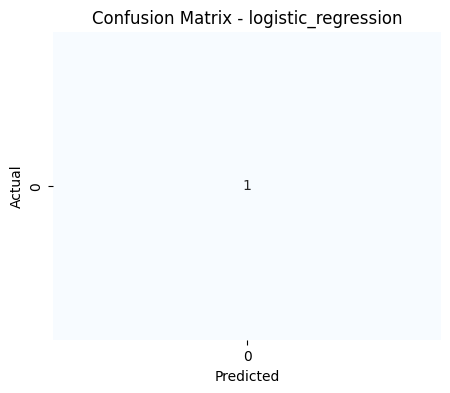

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:1179: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(


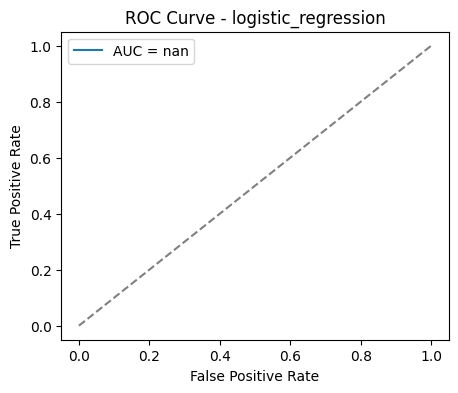

In [13]:
fig, ax = plt.subplots(figsize=(5,4))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(f'Confusion Matrix - {best_name}')
plt.show()

if y_proba_best is not None:
    fpr, tpr, _ = roc_curve(y_test, y_proba_best)
    auc = roc_auc_score(y_test, y_proba_best)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1],[0,1],'--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {best_name}')
    plt.legend()
    plt.show()
